## Risk + Porfolio

In [5]:
#### Imports ####
#################

### basics
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import copy
import pickle


### yahoo finance
import yfinance as yf

### pandas
import pandas as pd
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix


### data optimization library
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage,risk_matrix
from pypfopt import plotting

In [35]:
#### Functions ####
###################

def porfolio_weights(assets,risk, plot = False):
    '''
    Porfololio weights tal que se maximice el return según el riesgo que se quiera tomar
    
    Argumentos:
    dataset: (Dataframe) index:(Timestamp), cols:(float) stock price values
    first: ((list) shape=(3)) [(int) year,(int) month,(int) day]
    end:   ((list) shape=(3)) [(int) year,(int) month,(int) day]
    '''
    stock_ticker = assets.columns
    assets_selected = assets.loc[:,stock_ticker]
    mu = mean_historical_return(assets_selected,compounding = False)
    S = risk_matrix(assets)
    ef = EfficientFrontier(mu, S)


    ef = EfficientFrontier(mu, S)

    volatility = risk2var(risk,S)
    print(volatility)
    weights = ef.efficient_risk(volatility)
    ef.portfolio_performance(verbose=True)


    if plot:
        w_k, w_v = [],[]
        for k in weights.keys():
            w_k.append(k)
            w_v.append(weights[k])
            
        plt.bar(w_k,w_v)
        plt.xticks(rotation = 45);

    return weights

def split_train_test(dataset,first,end):
    '''
    Divide el dataset en train y test. El train está destinado para hacer el modelo de portfolios y el test para hacer el backtest 
    
    Argumentos:
    dataset: (Dataframe) index:(Timestamp), cols:(float) stock price values
    first: ((list) shape=(3)) [(int) year,(int) month,(int) day]
    end:   ((list) shape=(3)) [(int) year,(int) month,(int) day]
    '''

    first = [str(f) for f in first]
    end = [str(e) for e in end]

    y_1,m_1,d_1 = first
    y_2,m_2,d_2 = end

    #### Corrijo el formato de int a str, ej si me dan el día 1 de enero de 2014, el input es [2014,1,1] pero el string es 2014-01-01
    if len(m_1) == 1:
        m_1 = "0"+m_1
    if len(m_2) == 1:
        m_2 = "0"+m_2
    if len(d_1) == 1:
        d_1 = "0"+d_1
    if len(d_2) == 1:
        d_2 = "0"+d_2

    dataset = dataset.set_index("Date")
    dates_times = dataset.index
    dates = [fulldate.split(" ")[0] for fulldate in dates_times]

    
    try:
        idx_1 =  dates.index(f"{y_1}-{m_1}-{d_1}")
    except:
        print("No existe esa fecha para el BEGIN, probar otra")
        return

    try:
        idx_2 =  dates.index(f"{y_2}-{m_2}-{d_2}")
    except:
        print("No existe esa fecha para el END, probar otra")
        return
    
    return dataset[idx_1:idx_2],dataset[idx_2:]

def risk2var(risk,S):
    min_v = min(np.diag(S))
    max_v = max(np.diag(S))

    a = max_v -min_v
    b = min_v
    print(min_v,max_v)
    out = a*risk + b
    print(out)
    return np.sqrt(out)

def backtest(weights,dataset_test):

    ret_test_MR = np.dot(dataset_test.loc[:, weights.keys()], np.array(list(weights.values())))
    fig = plt.figure(figsize = (8,6))
    plt.plot(dataset_test.index,ret_test_MR/ret_test_MR[0])
    plt.xticks(dataset_test.index[::10],rotation = 45);
    return print("el porcentaje final de ganancia es de:", 100*ret_test_MR[-1]/ret_test_MR[0])


### Load Files

In [37]:
assets = pd.read_csv('../assets.csv')
filename = 'model/risk_model_2.p'
loaded_model = pickle.load(open(filename, 'rb'))

In [39]:
#### Train Test
assets_train,assets_test = split_train_test(assets,[2018,3,5],[2021,2,3])

### Imput Questions

In [9]:
edad = int(input("Edad:"))

In [10]:
nivel_educativo = int(input("Seleccione su nivel educativo:\n0- Sin educación\n1- Ed. diferencial\n2- Ed. Básica\n3- Ed. Media\n4- CFT o IP\n5- Universitaria\n6- Postgrado\n"))

In [11]:
estado_civil = int(input("Seleccione su estado civil:\n1- Casado\n2- Conviviente\n3- Anulado\n4- Separado\n5 Viudo\n6- Soltero\n7- Divorciado\n"))

In [14]:
ocup = int(input("Seleccione su estado de ocupación actual:\n0- Desocupado\n1- Ocupado\n"))

In [12]:
tr_numh = int(input("Seleccione el número de habitantes en su hogar:\n1- 1 o 2 personas\n2- 3 o 4 personas\n3- 5 o 6 personas\n5 más de 6 personas\n"))


act_tot = int(input("Ingrese un estimado de tu total de activos en pesos chilenos:\n"))
#estrato = int(input("Ingrese su estrato:\n1- \n6-\n9-"))
#rci_dt  = float(input("Ingrese rci ( entre 0 y 1):\n"))

In [15]:
X_imput = {"edad_ent" : edad,"neduc_ent" : nivel_educativo, "est_civil_ent": estado_civil, "ocup_ent":ocup, "tr_numh": tr_numh,"act_toth":act_tot}
#X_imput = {"edad_ent" : edad,"neduc_ent" : nivel_educativo, "est_civil_ent": estado_civil, "ocup_ent":ocup, "estrato":estrato, "tr_numh": tr_numh,"act_toth":act_tot,"rci_dt":rci_dt}

In [16]:
X_imput = pd.DataFrame(np.array(list(X_imput.values())).reshape(1,-1),columns = list(X_imput.keys()))

In [31]:
risk = loaded_model.predict(X_imput)[0]
print(risk)

0.46039042597264607


0.018208290554819647 0.08255500204273333
0.047832900466679186
0.21870733976407647
Expected annual return: 22.7%
Annual volatility: 21.9%
Sharpe Ratio: 0.94


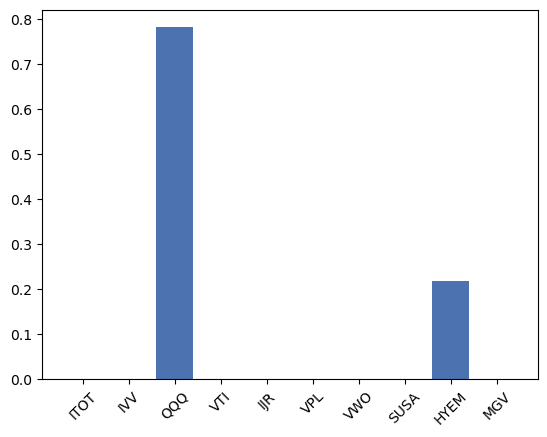

In [42]:
w8s = porfolio_weights(assets_train,risk,plot =True)

el porcentaje final de ganancia es de: 82.63724338549117


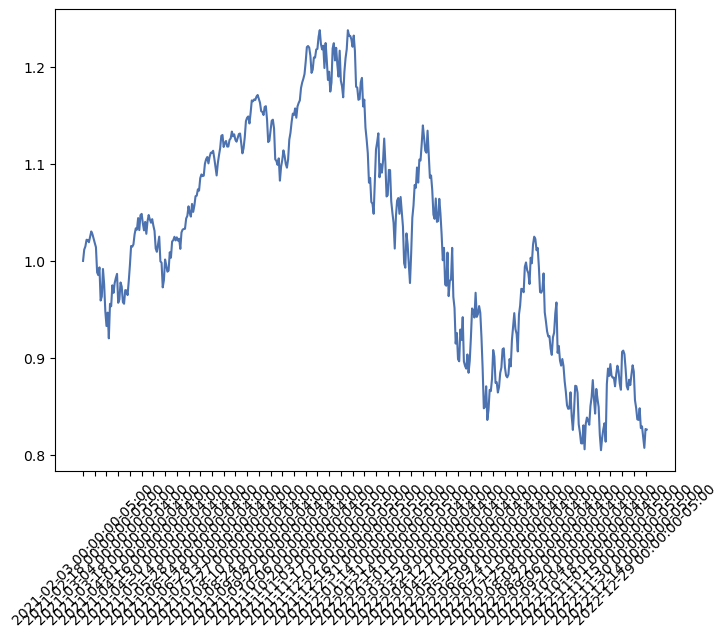

In [43]:
backtest(w8s,assets_test)